<a href="https://colab.research.google.com/github/mjgpinheiro/Econophysics/blob/main/TrendCountries2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

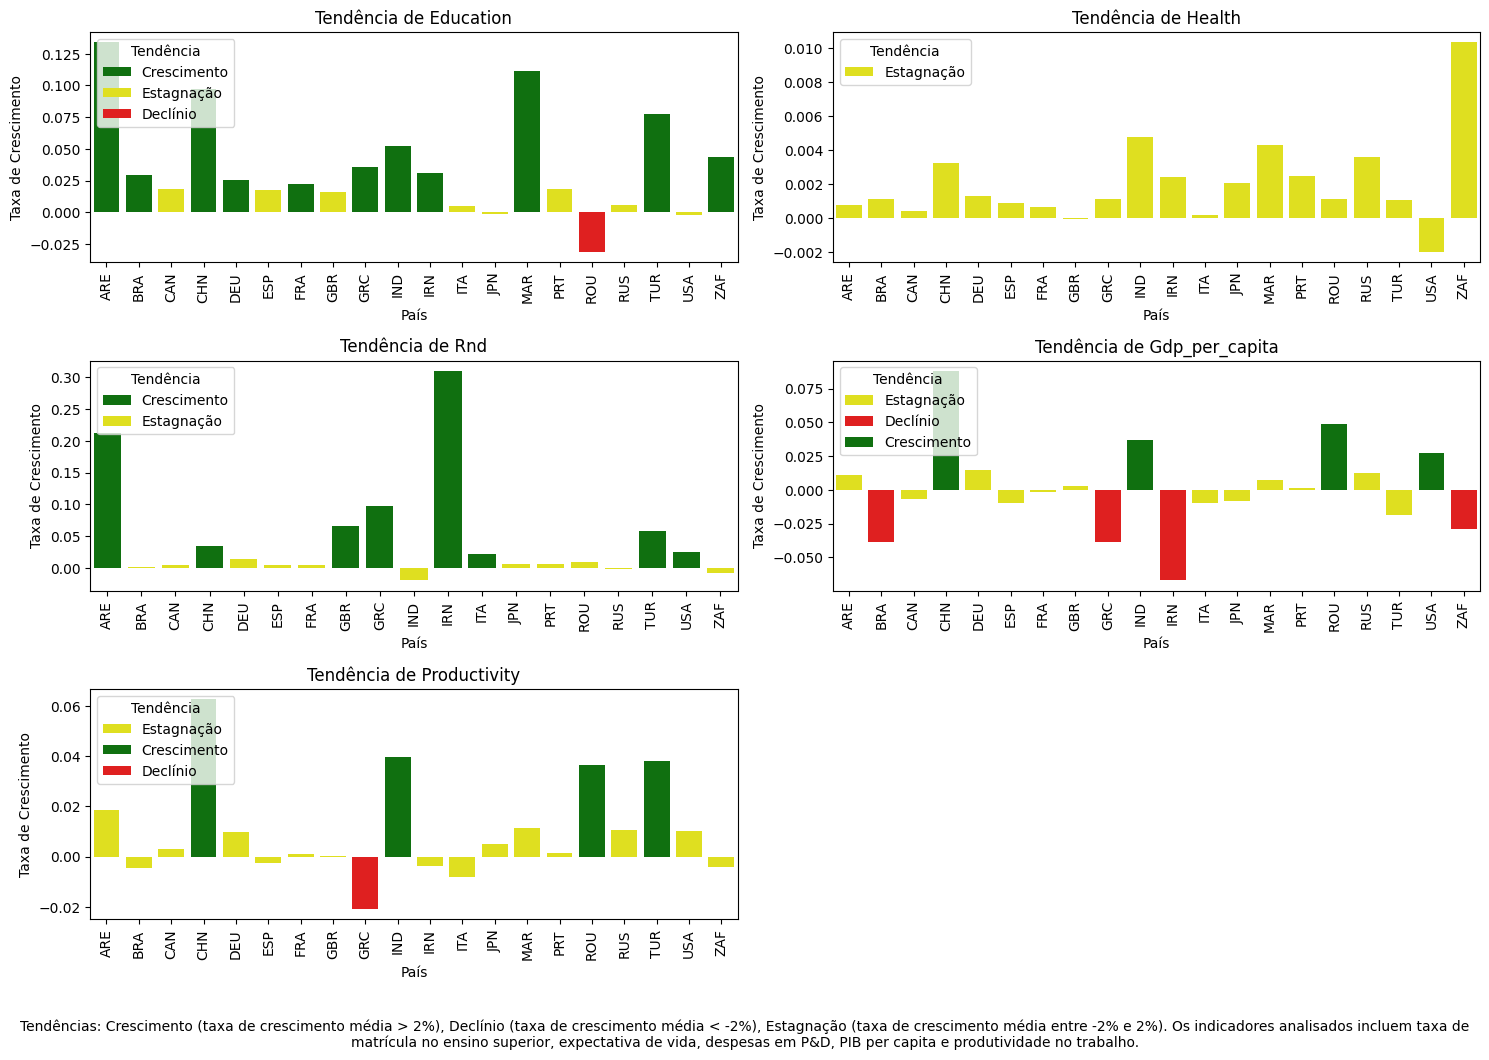

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Função para buscar dados da API do Banco Mundial
def fetch_world_bank_data(indicator, country_codes):
    all_data = []
    for country in country_codes:
        url = f"http://api.worldbank.org/v2/country/{country}/indicator/{indicator}?format=json&per_page=1000&date=2010:2020"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            if data and len(data) > 1:
                df = pd.DataFrame(data[1])
                df = df[['countryiso3code', 'date', 'value']].dropna().rename(columns={'countryiso3code': 'country', 'value': indicator})
                all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

# Lista de países (códigos ISO3) para incluir na análise
country_codes = ['USA', 'CAN', 'GBR', 'FRA', 'DEU', 'CHN', 'JPN', 'IND', 'BRA', 'ZAF', 'PRT', 'MAR', 'ESP', 'ROU', 'ITA', 'GRC', 'ARE', 'IRN', 'RUS', 'TUR']

# Buscar dados para diferentes indicadores
indicators = {
    'education': 'SE.TER.ENRR',  # Taxa de matrícula no ensino superior
    'health': 'SP.DYN.LE00.IN',  # Expectativa de vida
    'rnd': 'GB.XPD.RSDV.GD.ZS',  # Despesa em P&D (% do PIB)
    'gdp_per_capita': 'NY.GDP.PCAP.CD',  # PIB per capita como um proxy para felicidade
    'productivity': 'NY.GDP.PCAP.PP.KD'  # PIB por trabalhador (US$ constantes de 2011)
}

# Criar um DataFrame para armazenar os dados históricos
historical_data = {}
for key, indicator in indicators.items():
    historical_data[key] = fetch_world_bank_data(indicator, country_codes)

# Calcular a taxa de crescimento anual para cada indicador
growth_rates = {}
for key, df in historical_data.items():
    df['date'] = df['date'].astype(int)
    df.sort_values(by=['country', 'date'], inplace=True)
    df['growth_rate'] = df.groupby('country')[indicators[key]].pct_change()
    growth_rates[key] = df.dropna()

# Determinar a tendência predominante (crescimento, declínio, estagnação) para cada país
def classify_trend(df):
    trend_summary = df.groupby('country')['growth_rate'].mean().reset_index()
    trend_summary['trend'] = np.where(trend_summary['growth_rate'] > 0.02, 'Crescimento',
                                      np.where(trend_summary['growth_rate'] < -0.02, 'Declínio', 'Estagnação'))
    return trend_summary

trend_summaries = {key: classify_trend(df) for key, df in growth_rates.items()}

# Visualizar os dados
plt.figure(figsize=(15, 10))

trend_colors = {'Crescimento': 'green', 'Declínio': 'red', 'Estagnação': 'yellow'}

for i, (key, df) in enumerate(trend_summaries.items(), start=1):
    plt.subplot(3, 2, i)
    sns.barplot(data=df, x='country', y='growth_rate', hue='trend', dodge=False, palette=trend_colors)
    plt.title(f'Tendência de {key.capitalize()}')
    plt.xlabel('País')
    plt.ylabel('Taxa de Crescimento')
    plt.xticks(rotation=90)
    plt.legend(title='Tendência', loc='upper left')

plt.tight_layout()
plt.figtext(0.5, -0.05, ("Tendências: Crescimento (taxa de crescimento média > 2%), Declínio (taxa de crescimento média < -2%), "
                         "Estagnação (taxa de crescimento média entre -2% e 2%). Os indicadores analisados incluem taxa de matrícula "
                         "no ensino superior, expectativa de vida, despesas em P&D, PIB per capita e produtividade no trabalho."), wrap=True, horizontalalignment='center', fontsize=10)
plt.show()
